<center><h1> SIT799 Human Aligned Artificial Intelligence</h1></center>

<center><h2> 5.2D - DeepFakeComments Generator</h2></center>


Welcome to your assignment this week! 

To better understand the adverse use of AI, in this assignment, we will look at a Natural Language Processing use case.


Natural Language Pocessing (NLP) is a branch of Artificial Intelligence (AI) that helps computers to understand, to interpret and to manipulate natural (i.e. human) language.
Imagine NLP-powered machines as black boxes that are capable of understanding and evaluating the context of the input documents (i.e. collection of words), outputting meaningful results that depend on the task the machine is designed for.


<img src="imgs/1_3zMvUnPzYZF9CSHdj6hT5A.png" style="width:400px">
<caption><center> Documents are fed into magic NLP model capable to get, for instance, the sentiment of the original content</center></caption>


In this notebook, you will implement a model that uses an LSTM to generate fake tweets and comments. You will also be able to try it to generate your own fake text. 

**You will learn to:**
- Apply an LSTM to fake comment generation.
- Generate your own fake text with deep learning.

Please run the following cell to load all the packages required in this assignment. This may take a few minutes. 


In [ ]:
#!pip install numpy
#!pip install keras
#!pip install tensorflow

Run the following cell to load the packages you will need.

In [1]:
import time
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np

# Part 1: Build the model

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Let's define a tokenizer and read the data from disk.

In [4]:
tokenizer = Tokenizer(filters='"#$%&()*+-/:;<=>@[\\]^_`{|}~\t\n')
data = open('covid19_fake.txt').read().replace(".", " . ").replace(",", " , ").replace("?", " ? ").replace("!", " ! ")

Now, let's splits the data into tweets  where each line of the input file is a fake tweets.

We also extract the vocabulary of the data.

In [5]:
corpus = data.lower().split("\n")
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

You've loaded:
- `corpus`: an array where each entry is a fake post.
- `tokenizer`: which is the object that we will use to vectorize our dataset. This object also contains our word index.
- `total_words`: is the total number of words in the vacabulary.


In [6]:
print("Example of fake tweets: ",corpus[:2])
print("Size of the vocabulary = ", total_words)
index = [(k, v) for k, v in tokenizer.word_index.items()]
print("Example of our word index = ", index[0:10])

Example of fake tweets:  ['there is already a vaccine to treat covid19 . ', 'cleaning hands do not help to prevent covid19 . ']
Size of the vocabulary =  1257
Example of our word index =  [('.', 1), ('the', 2), ('covid19', 3), ('in', 4), ('to', 5), ('a', 6), ('of', 7), (',', 8), ('coronavirus', 9), ('and', 10)]


The next step aims to generate the training set of n_grams sequences.

In [7]:
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

You've create:
- `input_sequences`: which is a list of n_grams sequences.

In [8]:
sample = 20
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
print("The entry ",sample," in 'input_sequences' is: ")
print(input_sequences[sample])
print(" and it corresponds to:")
for i in input_sequences[sample]:
    print(reverse_word_map[i], end=' ')
                        

The entry  20  in 'input_sequences' is: 
[2, 3, 12, 187, 34, 188]
 and it corresponds to:
the covid19 is same as sars 

Next, we padd our training set to the max length in order to be able to make a batch processing.

In [9]:
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

Run the following to see the containt of the padded 'input_sequences' object.

In [10]:
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
print("The entry ",sample," in 'input_sequences' is: ")
print(input_sequences[sample])
print(" and it corresponds to:")
print("[", end=' ')
for i in input_sequences[sample]:
    if i in reverse_word_map:
        print(reverse_word_map[i], end=' ')
    else:
        print("__", end=' ')
print("]")
                

The entry  20  in 'input_sequences' is: 
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   2   3  12 187  34 188]
 and it corresponds to:
[ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ the covid19 is same as sars ]


Given a sentence like **"the covid19 is same as "**, we want to design a model that can predict the next word -- in the case the word **"sars"**.

Therefore, the next code prepares our input and output to our model consequently.

In [11]:
input_to_model, label = input_sequences[:,:-1],input_sequences[:,-1]


In [21]:
print("The entry ",sample," in 'input_sequences' is: ")
print(input_sequences[sample])
print(", it corresponds to the following input to our model:")
print(input_to_model[sample])
print(" and the following output: ", label[sample])


The entry  19  in 'input_sequences' is: 
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   2   3  12 187  34]
, it corresponds to the following input to our model:
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   2   3  12 187]
 and the following output:  [0. 0. 0. ... 0. 0. 0.]


In [20]:
sample = 19
print("The entry ",sample," in 'input_sequences' is: ")
print(input_sequences[sample])
print(", it corresponds to the following input to our model:")
print(input_to_model[sample])
print(" and the following output: ", label[sample])


The entry  19  in 'input_sequences' is: 
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   2   3  12 187  34]
, it corresponds to the following input to our model:
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   2   3  12 187]
 and the following output:  [0. 0. 0. ... 0. 0. 0.]


Finally, we convert our label to categorical labels for being processed by our model.

In [13]:
label = ku.to_categorical(label, num_classes=total_words)

Here is the architecture of the model we will use:

<img src="imgs/text_generation.png" style="width:600;height:400px;">




 
**Exercise**: Implement `deep_fake_comment_model()`. You will need to carry out 5 steps:

1. Create a sequencial model using the `Sequential` class
2. Add an embedding layer to the model using the `Embedding` class of size 128
3. Add an LSTM layer to the model using the `LSTM` class of size 128
4. Add a Dense layer to the model using the `Dense` class with a `softmax` activation
5. Set a `categorical_crossentropy` loss function to the model and optimize `accuracy`.


In [14]:
#TASK 1
# deep_fake_comment_model

def deep_fake_comment_model():
    ### START CODE HERE ### 
    model = Sequential(name="DeepFakeComment")
    model.add(Embedding(total_words, 128, input_length=max_sequence_len-1))
    model.add(LSTM(128))
    model.add(Dense(total_words, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
    ### END CODE HERE ### 
    return model
    
#Print details of the model.
model = deep_fake_comment_model()
model.summary()

Model: "DeepFakeComment"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 60, 128)           160896    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 1257)              162153    
Total params: 454,633
Trainable params: 454,633
Non-trainable params: 0
_________________________________________________________________


Now, let's start our training.

In [15]:
history = model.fit(input_to_model, label, epochs=200, batch_size=32, verbose=1)

Epoch 1/200
126/126 [==============================] - 32s 9ms/step - loss: 6.6099 - accuracy: 0.0681
Epoch 2/200
126/126 [==============================] - 1s 8ms/step - loss: 5.9380 - accuracy: 0.0707
Epoch 3/200
126/126 [==============================] - 1s 8ms/step - loss: 5.7201 - accuracy: 0.0867
Epoch 4/200
126/126 [==============================] - 1s 8ms/step - loss: 5.5469 - accuracy: 0.1187
Epoch 5/200
126/126 [==============================] - 1s 8ms/step - loss: 5.4020 - accuracy: 0.1309
Epoch 6/200
126/126 [==============================] - 1s 8ms/step - loss: 5.2701 - accuracy: 0.1340
Epoch 7/200
126/126 [==============================] - 1s 8ms/step - loss: 5.0928 - accuracy: 0.1527
Epoch 8/200
126/126 [==============================] - 1s 8ms/step - loss: 4.8435 - accuracy: 0.1570
Epoch 9/200
126/126 [==============================] - 1s 9ms/step - loss: 4.6721 - accuracy: 0.1889
Epoch 10/200
126/126 [==============================] - 1s 8ms/step - loss: 4.4457 - accur

Let's plot details of our training.

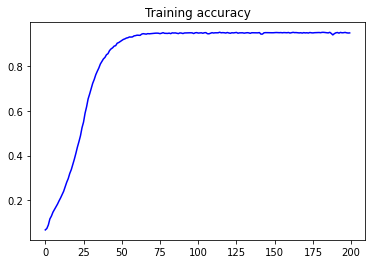

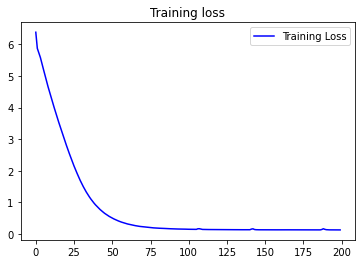

In [16]:
acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()
plt.show()

# Part 2: Generating fake comments

To generate fake tweets, we use the below architecture:

<img src="imgs/text_gen.png" style="width:600;height:400px;">

The idea is to give one or more starting token(s) to our model, and generate the next tokens until we generate `.`.

At each step, we select the token with the highest probability as our next token and generate the next one similartly using `model.predict_classes()`. 

**Note:** The model takes as input the activation `a` from the previous state of the LSTM and the token chosen, forward propagate by one step, and get a new output activation `a`. The new activation `a` can then be used to generate the output, using the `dense` layer with `softmax` activation as before. 



In [ ]:
tokenizer.word_index.items()

dict_items([('.', 1), ('the', 2), ('covid19', 3), ('in', 4), ('to', 5), ('a', 6), ('of', 7), (',', 8), ('coronavirus', 9), ('and', 10), ('says', 11), ('is', 12), ('for', 13), ('can', 14), ('from', 15), ('that', 16), ('are', 17), ('people', 18), ('with', 19), ('you', 20), ('virus', 21), ('on', 22), ('it', 23), ('or', 24), ('will', 25), ('was', 26), ('your', 27), ('has', 28), ('be', 29), ('kill', 30), ('!', 31), ('at', 32), ('not', 33), ('as', 34), ('have', 35), ('all', 36), ('this', 37), ('china', 38), ('trump', 39), ('by', 40), ('prevent', 41), ('new', 42), ('drinking', 43), ('they', 44), ('flu', 45), ('get', 46), ('out', 47), ('there', 48), ('vaccine', 49), ('days', 50), ('spread', 51), ('water', 52), ('lab', 53), ('shows', 54), ('pandemic', 55), ('so', 56), ('home', 57), ('against', 58), ('outbreak', 59), ('president', 60), ('donald', 61), ('if', 62), ('because', 63), ('only', 64), ('us', 65), ('been', 66), ('do', 67), ('being', 68), ('more', 69), ('protect', 70), ('one', 71), ('wuha

In [17]:
#TASK 2
# Implement the generate() function

def generate(seed_text):
    ### START CODE HERE ### 
    text = seed_text    
    while True:
        token_list = tokenizer.texts_to_sequences([text])
        
        token_list = np.array([np.array(token_list[0])])
        print(token_list)
#         print(type((token_list[0])))
#         token_list = pad_sequences(token_list, maxlen=6, padding='pre')
#         print(type(token_list[0]))
#         print('--------')
        predicted = model.predict_classes(token_list, verbose=0)
        
        
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break        
        text += " " + output_word
        if output_word == '.' or output_word == '?' or output_word == '!':
            break
    return text
### END CODE HERE ### 


**Let's test it:**

In [18]:
print(generate("COVID19 virus"))
# print(generate("COVID19 is the"))
# print(generate("The usa is"))
# print(generate("The new virus"))
# print(generate("China has"))


[[ 3 21]]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[  3  21 157]]
[[  3  21 157 347]]
[[  3  21 157 347 218]]
[[  3  21 157 347 218 218]]
[[  3  21 157 347 218 218 218]]
[[  3  21 157 347 218 218 218 218]]
[[  3  21 157 347 218 218 218 218 239]]
[[  3  21 157 347 218 218 218 218 239 122]]
[[  3  21 157 347 218 218 218 218 239 122 266]]
[[  3  21 157 347 218 218 218 218 239 122 266 469]]
[[   3   21  157  347  218  218  218  218  239  122  266  469 1042]]
[[   3   21  157  347  218  218  218  218  239  122  266  469 1042  243]]
[[   3   21  157  347  218  218  218  218  239  122  266  469 1042  243
  1042]]
[[   3   21  157  347  218  218  218  218  239  122  266  469 1042  243
  1042   86]]
[[   3   21  157  347  218  218  218  218  239  122  266  469 1042  243
  1042   86   70]]
[[   3   21  157  347  218  218  218  218  239  122  266  469 1042  243
  1042   86   70   42]]
[[   3   21  157  347  218  218  218  218  239  122  266  469 1042  243
  1042   86   70   42   71]]
[[   3   21  157  347  218  218  218  218  239  122  266  469 

**Let's test it in an interactive mode:**

In [19]:
usr_input = input("Write the beginning of your tweet, the algorithm machine will complete it. Your input is: ")
for w in generate(usr_input).split():    
    print(w, end =" ")
    time.sleep(0.4)


Write the beginning of your tweet, the algorithm machine will complete it. Your input is: COVID19 is
[[ 3 12]]
[[ 3 12  4]]
[[ 3 12  4 88]]
[[  3  12   4  88 524]]
[[  3  12   4  88 524 103]]
COVID19 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


is in their lung disease . 

## Generating text by sampling

The previous part is generating text by choosing the token with the highest probability. Now, we sill generate text by sampling as shown in the architecture below:

<img src="imgs/text_gen_sample.png" style="width:600;height:400px;">


To sample a token from the output at each timestep, you need to use the following two functions:
- `model.predict_proba()`: To get probabilities from the output layer.
- `np.random.choice()`: To sample from the token list using the probaility array of each token.



In [ ]:
#TASK 3
# Implement the generate_sample() function
def generate_sample(seed_text):
   ### START CODE HERE ### 
   pass
    ### END CODE HERE ### 

## Part 3: Generate your own text 

Below, find data to generate other content for a different application:

### Congratulations!

You've come to the end of this assignment, and have seen how to build a deep learning architecture that generate fake tweets/comments. 

Congratulations on finishing this notebook! 

